<div style="background-image: linear-gradient(transparent, white 85%),url('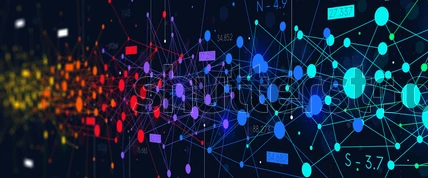'); min-height: 350px; background-repeat: no-repeat; background-size: cover;"></div><h1 style="font-size: 220%; margin-top: -120px; text-align: center;">Trabalho Final - Deep Learning I</h1>


Usando o dataset abaixo, treine um MLP (classificação) e obtenha uma acurácia maior que 70% no conjunto de teste.

1. Use 80% da base para treino e 20% para teste.
2. Pode usar a implementação da Scikit-Learn.
3. Como é RNA, os dados precisam estar na mesma escala. Realize a normalização. 
4. Quebre a coluna rank em outras colunas (a depender da quantidade de elementos distintos existentes na coluna rank) usando get_dumies do pandas.

## Trabalho desenvolvido durante o MBA em Data Science / IA na FIAP - 2022~2023.

## Prof. Dheny Fernandes

## 1) Imports & Setup

### 1.1) Imports das bibliotecas e módulos usados

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import shapiro

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns

%matplotlib inline

### Definição da semente de randomização
<div style="display: flex;">
    <div style="flex: 1; padding: 10px; text-size:12px; width:75%;">
        Fun-fact: 311 foi uma homenagem ao Windows 3.11 que fez 25 anos de aniversário recentemente
    </div>
    <div style="flex: 1; padding: 10px;width:25%;">
        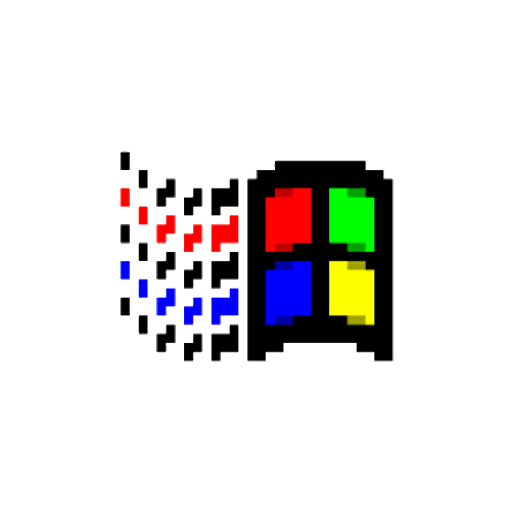
    </div>
</div>

In [2]:
RANDOMSTATE = 311

## 2) Carga do dataset

In [3]:
data = pd.read_csv('student_data.csv')
data.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


## 3) Análise Exploratória dos Dados

Vamos plotar gráficos para tentar identificar padrões visuais, se existirem. Como temos 3 variáveis explicativas, faremos também um gráfico em 3D com as 3 variáveis colorindo com a variável target, para auxiliar nesta tarefa.

### 3.1) Gráfico Scatter Test (GRE) x Grades (GPA)

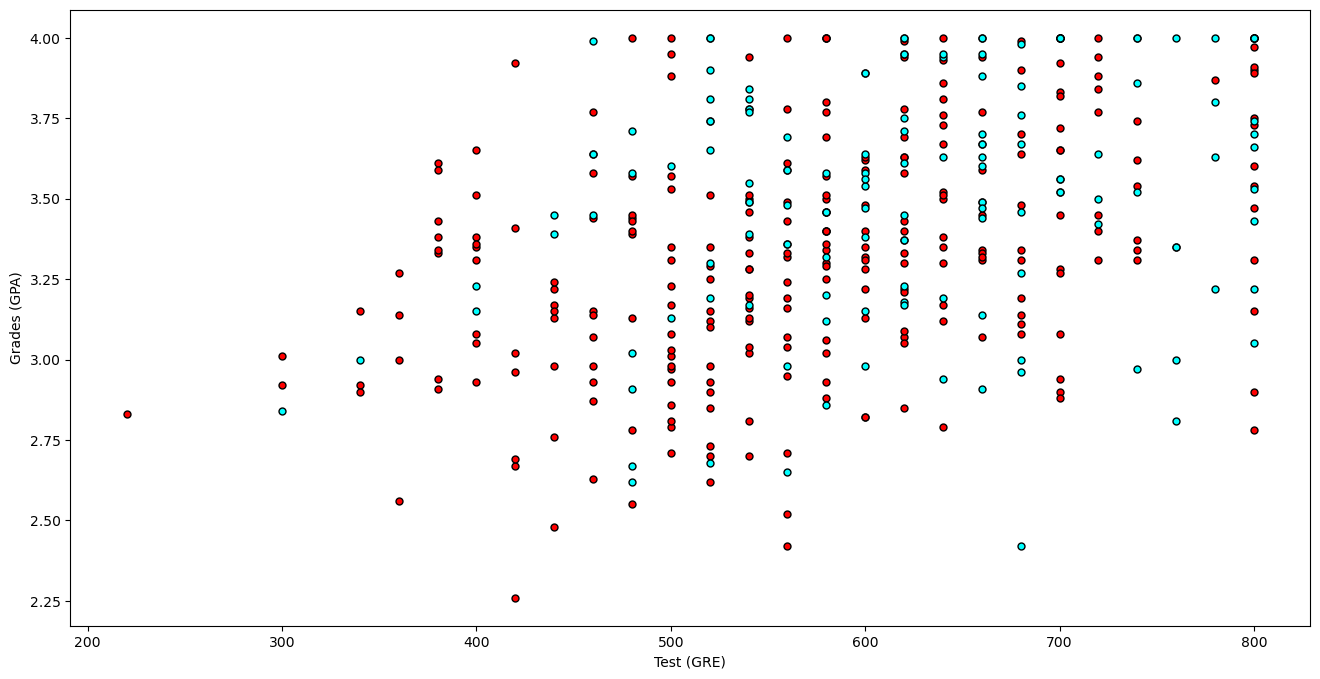

In [4]:
# Função auxiliar para visualizar os dados

def plot_points(data):
    X = np.array(data[["gre","gpa"]])
    y = np.array(data["admit"])
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plt.figure(figsize=(16,8))
    plt.scatter([s[0][0] for s in rejected],
                [s[0][1] for s in rejected],
                s = 25, color = 'red',
                edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted],
                [s[0][1] for s in admitted],
                s = 25, color = 'cyan',
                edgecolor = 'k')
    plt.xlabel('Test (GRE)')
    plt.ylabel('Grades (GPA)')
    
plot_points(data)
plt.show()

### 3.2) Gráfico Scatter por Rank (1~4)

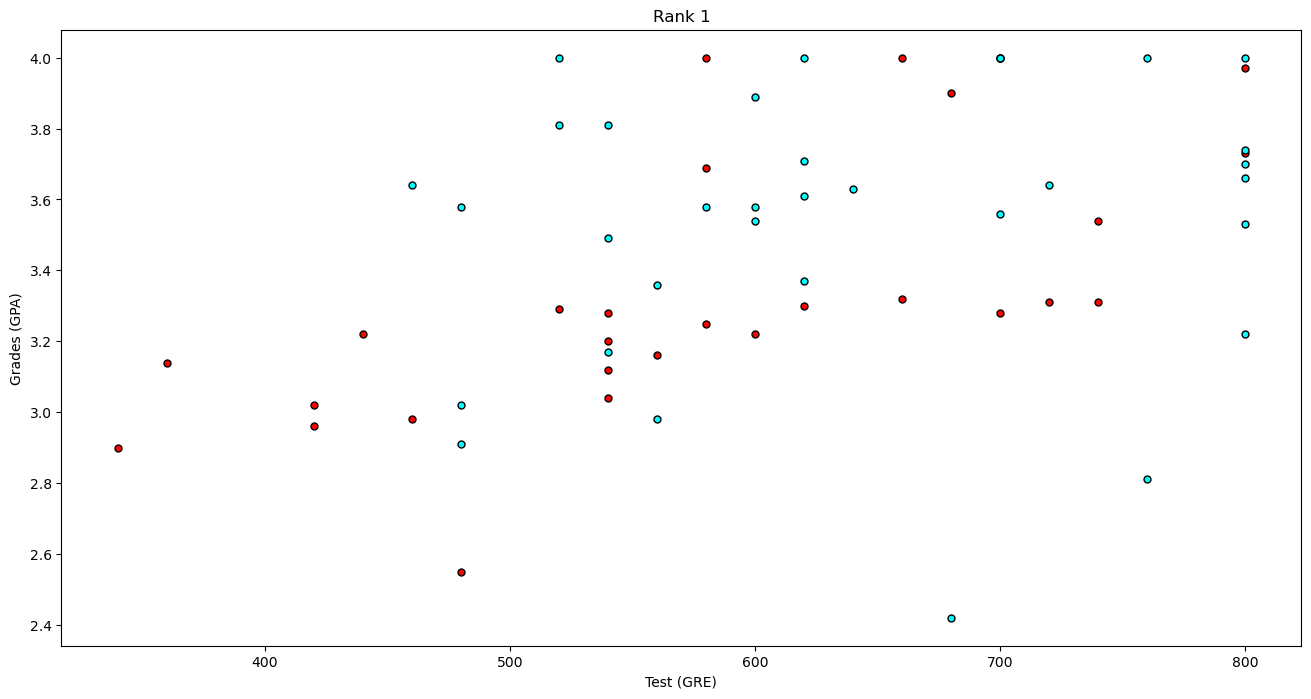

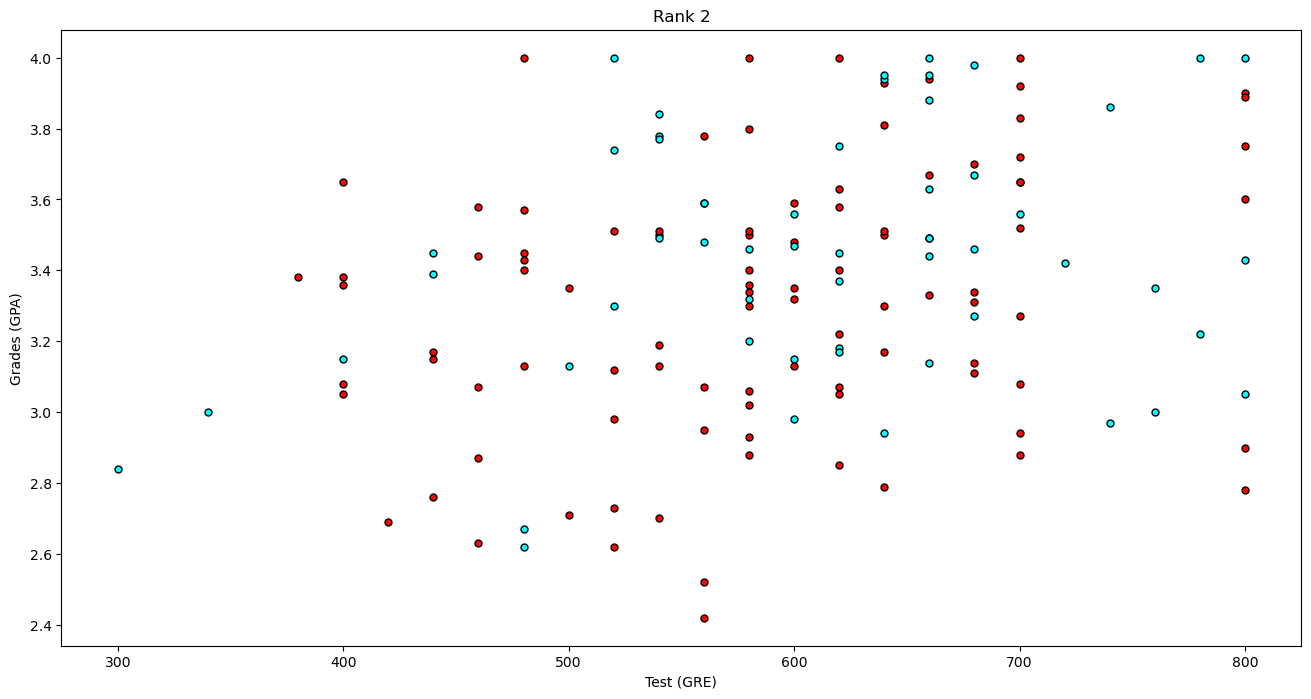

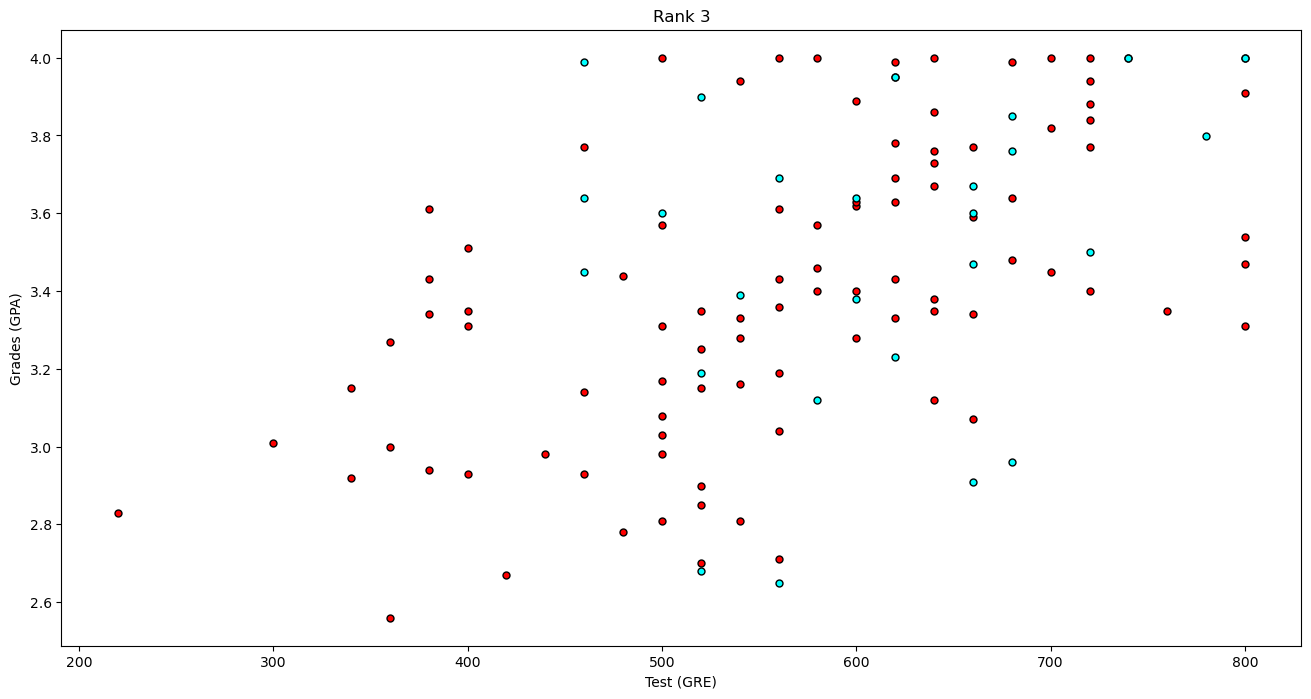

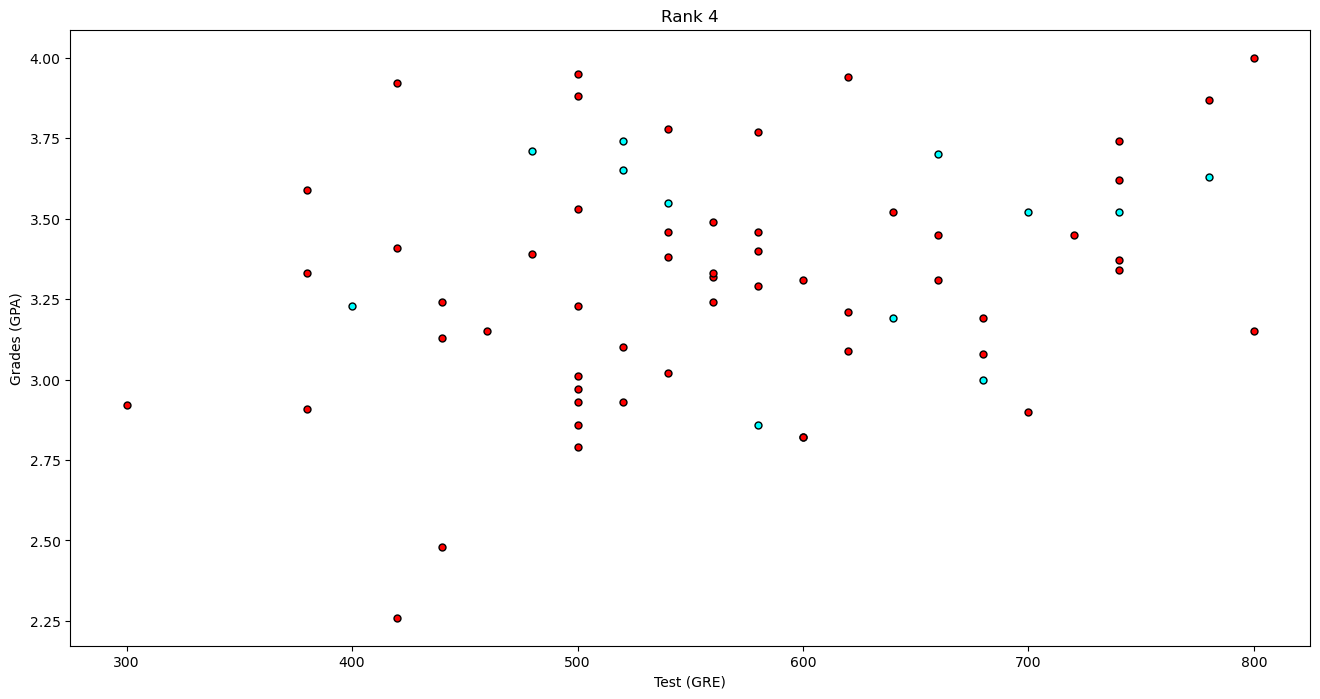

In [5]:
# Plotando usando a variável rank

data_rank1 = data[data["rank"]==1]
data_rank2 = data[data["rank"]==2]
data_rank3 = data[data["rank"]==3]
data_rank4 = data[data["rank"]==4]

plot_points(data_rank1)
plt.title("Rank 1")
plt.show()
plot_points(data_rank2)
plt.title("Rank 2")
plt.show()
plot_points(data_rank3)
plt.title("Rank 3")
plt.show()
plot_points(data_rank4)
plt.title("Rank 4")
plt.show()

### 3.3) Gráfico 3D Test (GRE) x Grades (GPA) x Rank

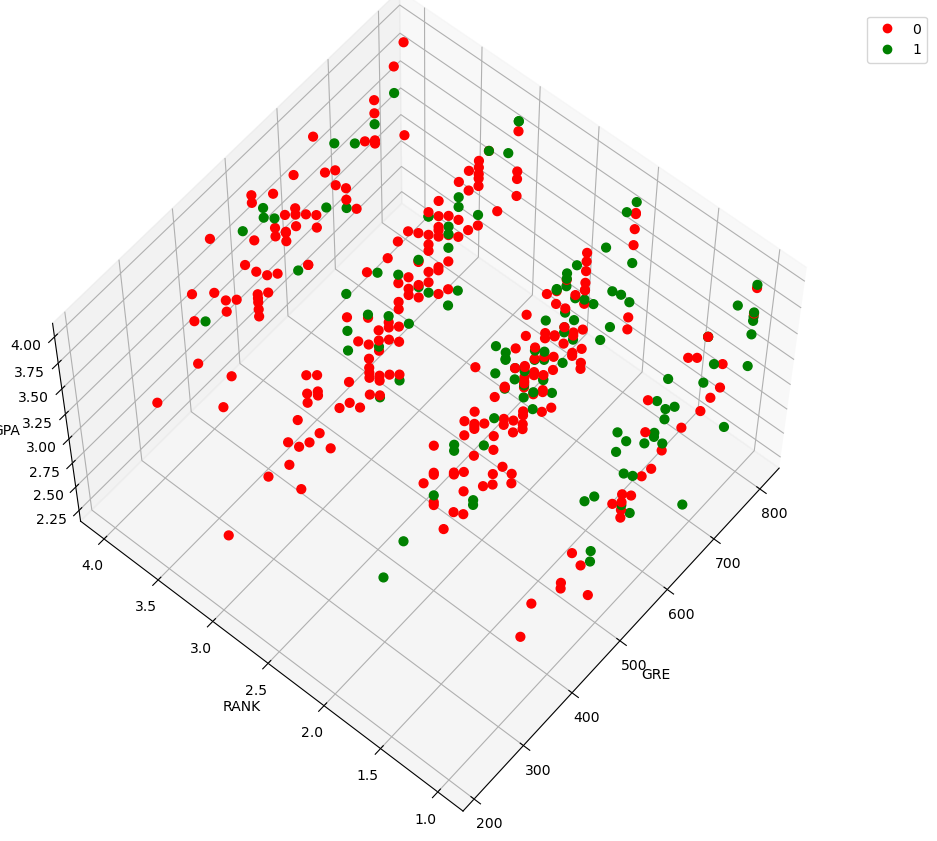

In [6]:
# Dados para o plot 3D

x = data['gre']
z = data['gpa']
y = data['rank']

fig = plt.figure(figsize = (12, 8))
ax = Axes3D(fig, auto_add_to_figure = False)
fig.add_axes(ax)

# Dar cor a partir da variável admit, 0 = vermelho, 1 = verde
colors = ['red', 'green']

sc = ax.scatter(x, y, z, s = 40,
                c = data['admit'],
                marker='o',
                cmap = matplotlib.colors.ListedColormap(colors),
                alpha = 1)
ax.set_xlabel('GRE')
ax.set_ylabel('RANK')
ax.set_zlabel('GPA')

# Legenda
plt.legend(*sc.legend_elements(),
           bbox_to_anchor = (1.05, 1),
           loc = 2)

ax.view_init(59, 220)


### 3.4) Análise Gráfica - Boxplot, histograma densidade

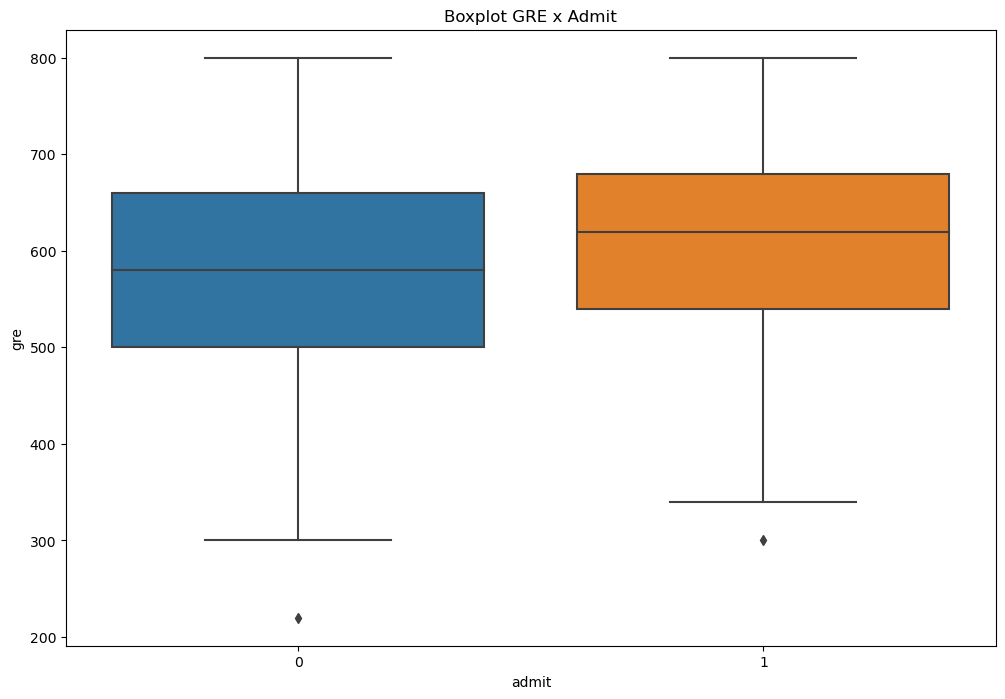

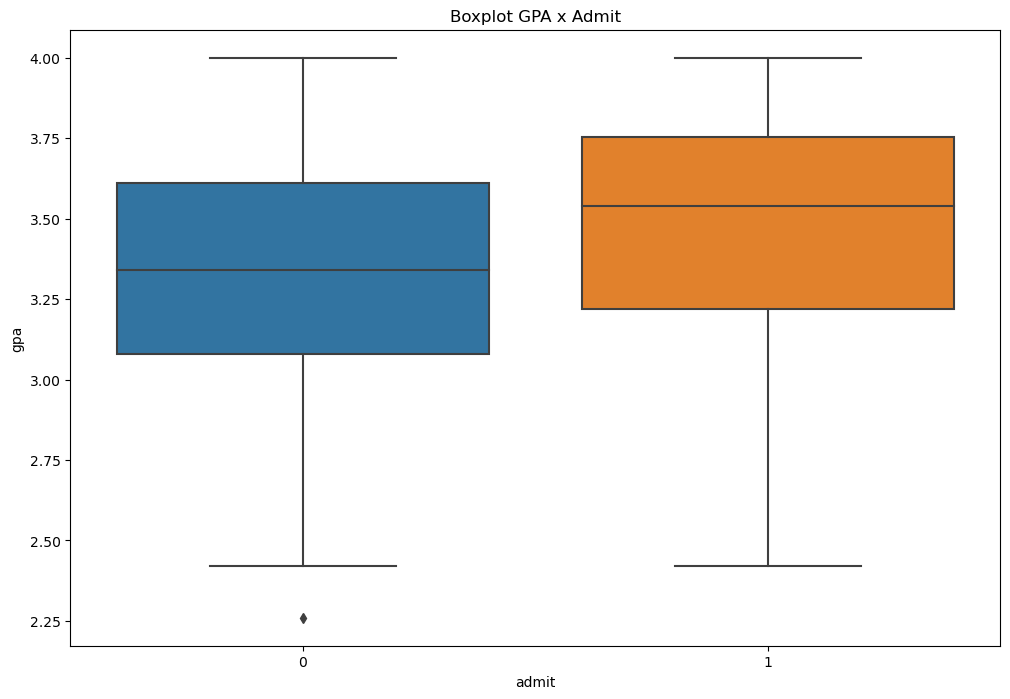

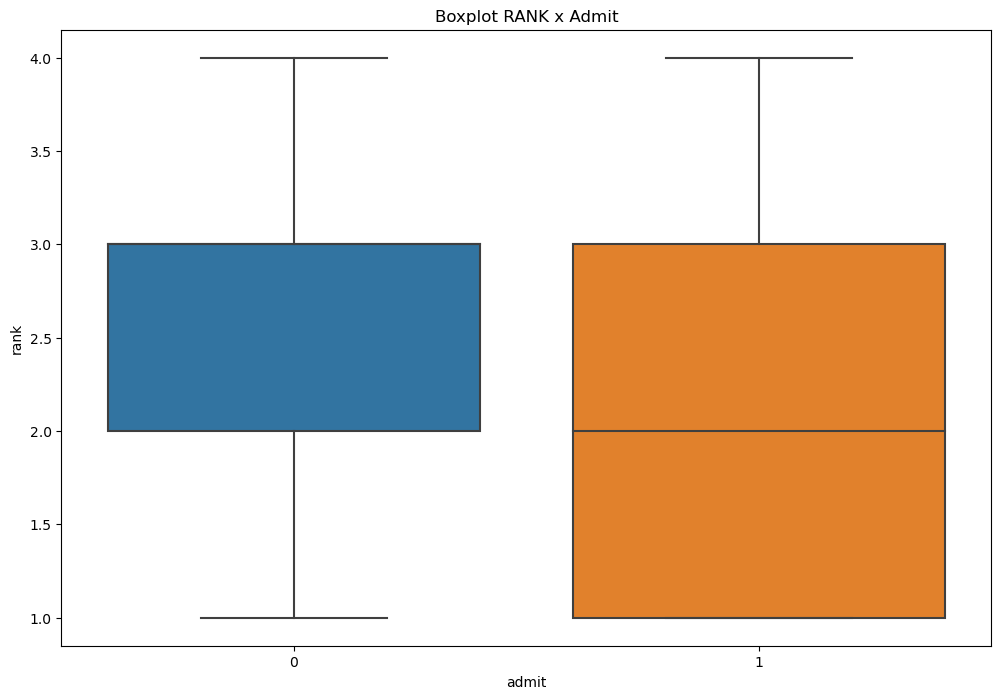

In [7]:
fig = plt.figure(figsize = (12, 8))
ax = sns.boxplot(x="admit", y="gre", data = data)
ax.set_title('Boxplot GRE x Admit')
plt.show()

fig = plt.figure(figsize = (12, 8))
ax = sns.boxplot(x="admit", y="gpa", data = data)
ax.set_title('Boxplot GPA x Admit')
plt.show()

fig = plt.figure(figsize = (12, 8))
ax = sns.boxplot(x="admit", y="rank", data = data)
ax.set_title('Boxplot RANK x Admit')
plt.show()

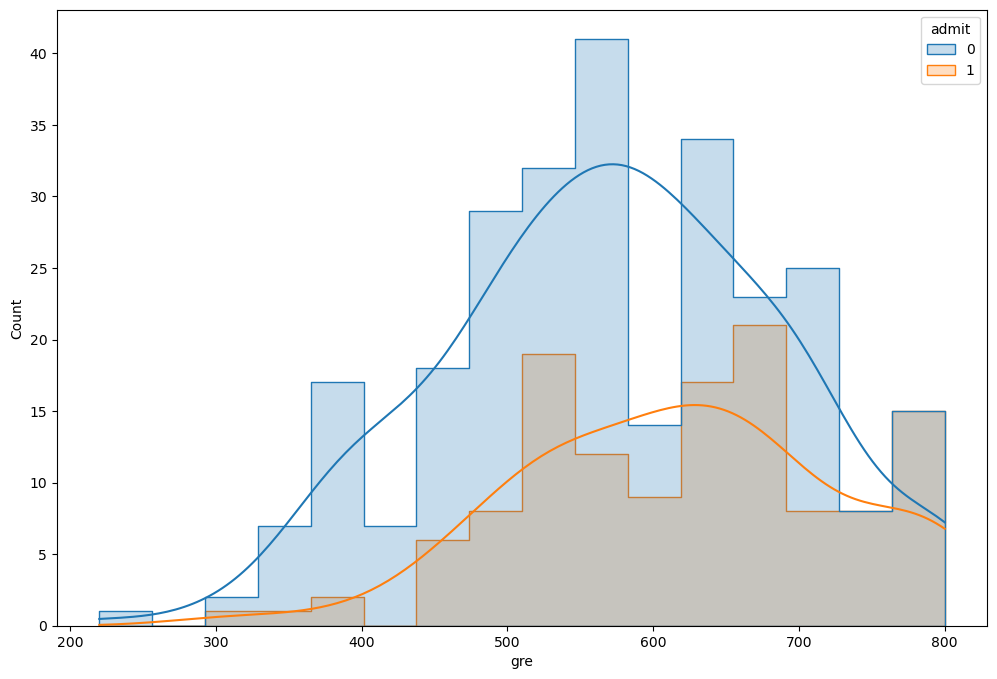

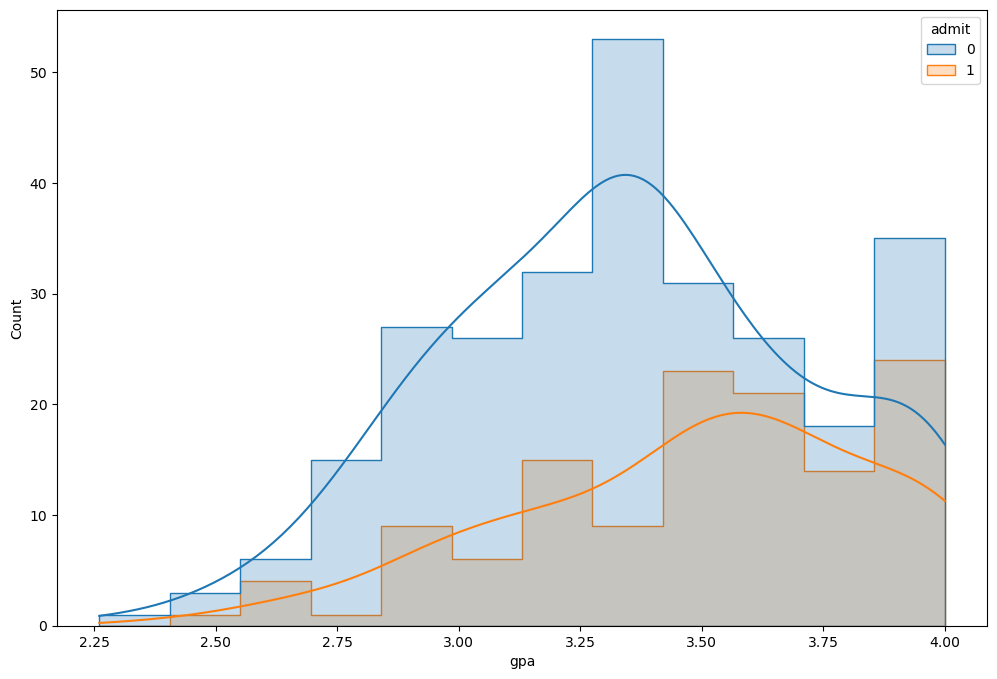

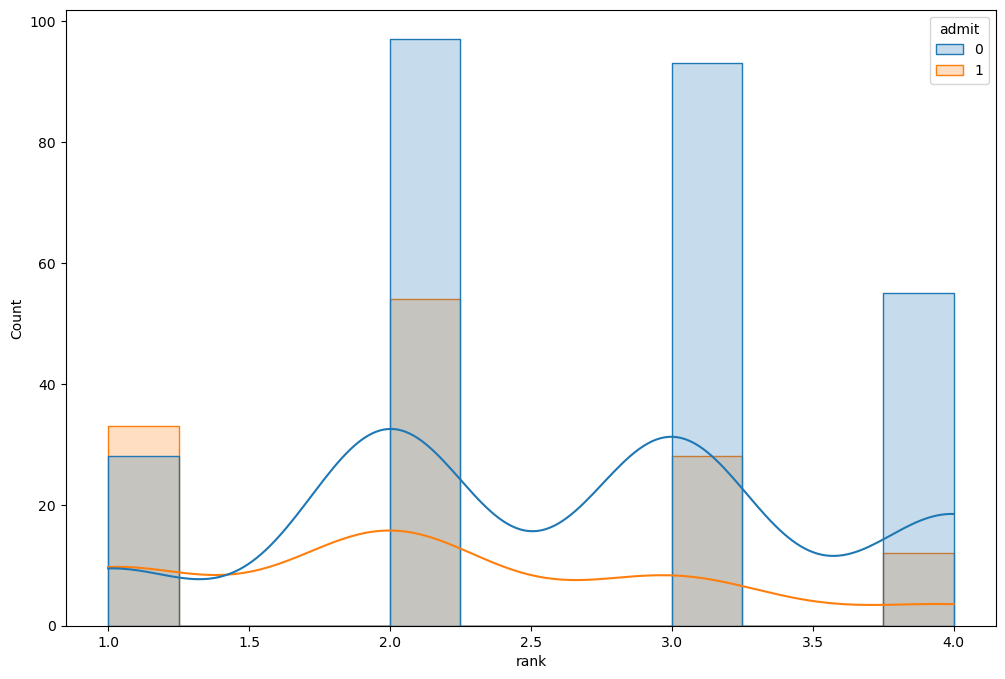

In [8]:
fig = plt.figure(figsize = (12, 8))
ax = sns.histplot(x = "gre", data = data, hue = "admit", element = "step", kde = True)
plt.show()

fig = plt.figure(figsize = (12, 8))
ax = sns.histplot(x = "gpa", data = data, hue = "admit", element = "step", kde = True)
plt.show()

fig = plt.figure(figsize = (12, 8))
ax = sns.histplot(x = "rank", data = data, hue = "admit", element = "step", kde = True)
plt.show()

### 3.5) Verificação de nulos/missing

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   admit   400 non-null    int64  
 1   gre     400 non-null    int64  
 2   gpa     400 non-null    float64
 3   rank    400 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 12.6 KB


In [10]:
data.isnull().values.any()

False

Nenhuma das features apresentou valores nulos / missing e não identificamos grandes discrepâncias/outliers nos dados.

### 3.5) Estatísticas Descritivas

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
admit,400.0,0.3175,0.466087,0.00,0.00,0.000,1.00,1.0
gre,400.0,587.7000,115.516536,220.00,520.00,580.000,660.00,800.0
gpa,400.0,3.3899,0.380567,2.26,3.13,3.395,3.67,4.0
rank,400.0,2.4850,0.944460,1.00,2.00,2.000,3.00,4.0


### 3.6) Matriz de Correlação

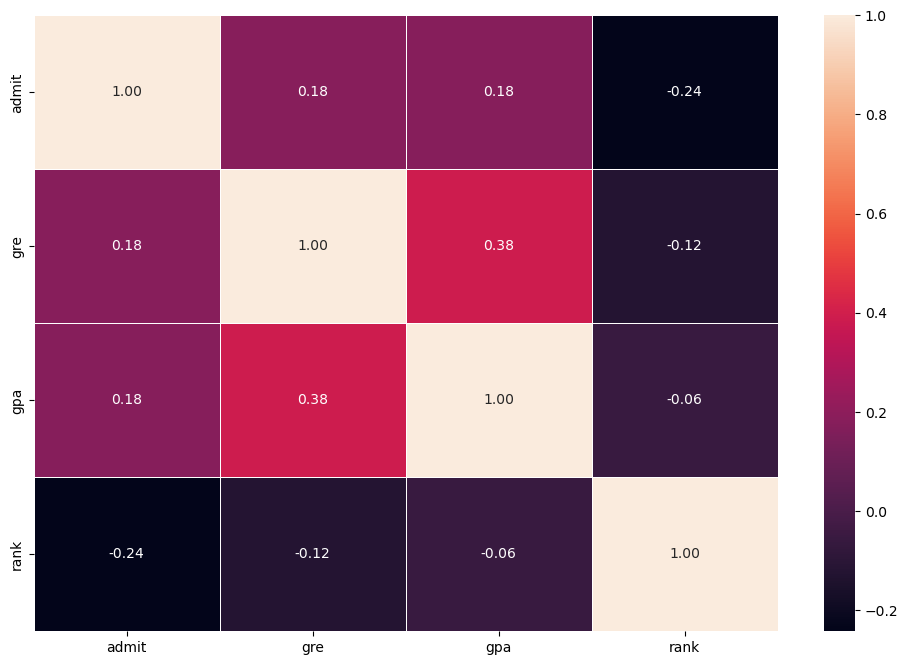

In [12]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), annot = True,
            fmt=".2f", linewidths=.6)
plt.show()

## 4) Pré-processamento dos Dados

### 4.1) Criação de Dummies

In [13]:
# Cópia do dataset para preservar os dados originais
m_data = data.copy()

# Criação das dummies para a feature rank
m_data = pd.get_dummies(m_data, prefix=['rank'],
                        columns=['rank'],
                        drop_first = False)

# Verificação do dataset
display(m_data.head(5))
display(m_data.tail(5))

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,380,3.61,0,0,1,0
1,1,660,3.67,0,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,0,0,0,1
4,0,520,2.93,0,0,0,1


,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
395,0,620,4.00,0,1,0,0
396,0,560,3.04,0,0,1,0
397,0,460,2.63,0,1,0,0
398,0,700,3.65,0,1,0,0
399,0,600,3.89,0,0,1,0


### 4.1.1) Matriz de correlação

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
admit,1.000000,0.184434,0.178212,0.203651,0.067109,-0.121800,-0.133356
gre,0.184434,1.000000,0.384266,0.088622,0.056202,-0.073200,-0.068235
gpa,0.178212,0.384266,1.000000,0.070550,-0.057867,0.074490,-0.084428
rank_1,0.203651,0.088622,0.070550,1.000000,-0.330334,-0.279354,-0.190274
rank_2,0.067109,0.056202,-0.057867,-0.330334,1.000000,-0.512837,-0.349304
rank_3,-0.121800,-0.073200,0.074490,-0.279354,-0.512837,1.000000,-0.295397
rank_4,-0.133356,-0.068235,-0.084428,-0.190274,-0.349304,-0.295397,1.000000


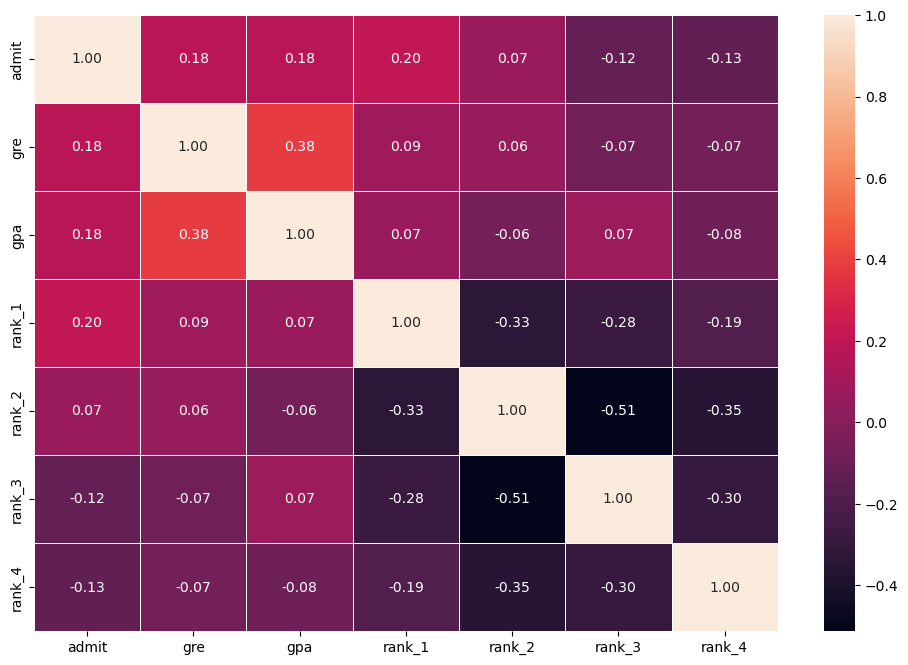

In [14]:
display(m_data.corr())
plt.figure(figsize=(12,8))
sns.heatmap(m_data.corr(), annot = True,
            fmt=".2f", linewidths=.6)
plt.show()

### 4.1.2) Matriz de correlação após drop de uma das colunas após `get_dummies`

,admit,gre,gpa,rank_1,rank_3,rank_4
admit,1.000000,0.184434,0.178212,0.203651,-0.121800,-0.133356
gre,0.184434,1.000000,0.384266,0.088622,-0.073200,-0.068235
gpa,0.178212,0.384266,1.000000,0.070550,0.074490,-0.084428
rank_1,0.203651,0.088622,0.070550,1.000000,-0.279354,-0.190274
rank_3,-0.121800,-0.073200,0.074490,-0.279354,1.000000,-0.295397
rank_4,-0.133356,-0.068235,-0.084428,-0.190274,-0.295397,1.000000


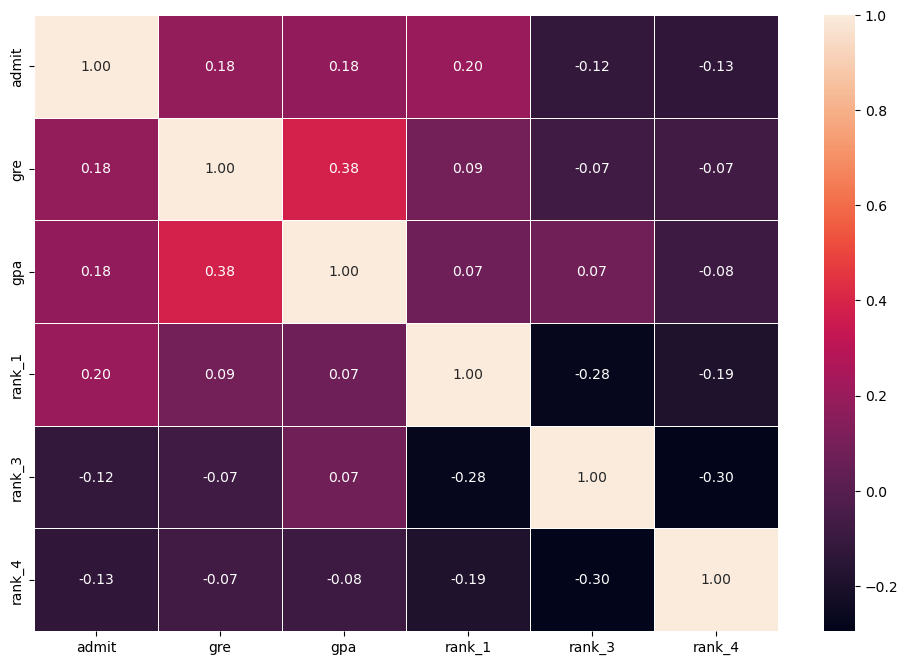

In [15]:
m_data.drop(columns = ['rank_2'], inplace=True)

display(m_data.corr())
plt.figure(figsize=(12,8))
sns.heatmap(m_data.corr(), annot = True,
            fmt=".2f", linewidths=.6)
plt.show()

Após a aplicação da técnica de codificação one-hot nas variáveis categóricas usando o método `get_dummies`, realizamos uma análise da matriz de correlação entre as variáveis resultantes. Identificamos que a coluna **'rank_2'**, gerada pelo `get_dummies`, apresentou uma correlação forte, com um valor absoluto de 0.51 em relação a outra variável. Essa alta correlação pode indicar a presença de multicolinearidade.

Com o objetivo de mitigar os efeitos da multicolinearidade, optamos por remover a coluna **'rank_2'** antes de prosseguir com a modelagem. Essa decisão foi baseada na necessidade de garantir a independência das variáveis explicativas, evitando assim distorções nos resultados.

Durante os estudos, comparamos os resultados do modelo antes e depois dessa modificação, e observamos pouca mudança na acurácia. No entanto, o resultado geral se mostrou melhor, indicando que a remoção da coluna *'rank_2'* contribuiu para uma melhor representação dos dados e um modelo mais robusto.

### 4.2) Separação dos dados em treino e teste

In [16]:
X = m_data[['gre', 'gpa', 'rank_1', 'rank_3', 'rank_4']]
y = m_data['admit']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state = RANDOMSTATE)

display(X_train.describe().T)
display(X_test.describe().T)

,count,mean,std,min,25%,50%,75%,max
gre,320.0,589.750000,117.015927,220.00,515.0000,580.0,680.00,800.0
gpa,320.0,3.390000,0.387836,2.26,3.1175,3.4,3.67,4.0
rank_1,320.0,0.146875,0.354536,0.00,0.0000,0.0,0.00,1.0
rank_3,320.0,0.296875,0.457597,0.00,0.0000,0.0,1.00,1.0
rank_4,320.0,0.175000,0.380562,0.00,0.0000,0.0,0.00,1.0


,count,mean,std,min,25%,50%,75%,max
gre,80.0,579.5000,109.635761,340.00,520.0000,580.000,645.000,800.0
gpa,80.0,3.3895,0.352291,2.62,3.1375,3.365,3.625,4.0
rank_1,80.0,0.1750,0.382364,0.00,0.0000,0.000,0.000,1.0
rank_3,80.0,0.3250,0.471330,0.00,0.0000,0.000,1.000,1.0
rank_4,80.0,0.1375,0.346547,0.00,0.0000,0.000,0.000,1.0


### 4.3) Normalização das *Features* GRE e GPA

Para decidir se iremos normalizar usando StandardScaler, RobustScaler ou uma função própria/customizada, vamos verificar se a distribuição das variáveis GRE e GPA segue uma normal.

O StandardScaler utiliza a padronização z-score, que transforma os dados para terem média 0 e desvio padrão igual a 1. Essa técnica assume uma distribuição normal dos dados e pode não ser adequada para o conjunto de dados se este não tiver uma distribuição normal. 

Faremos o teste de normalizade Shapiro e então decidiremos qual normalização faremos.

In [17]:
for var in ['gre', 'gpa']:
    dttn = m_data[var]

    # Teste de normalidade de Shapiro-Wilk
    stat, p_value = shapiro(dttn)

    # Imprimir os resultados
    print('Estatística de teste:', stat)
    print('Valor p:', p_value)

    # Interpretação dos resultados
    alpha = 0.05  # Nível de significância
    if p_value > alpha:
        print('A distribuição da variável %s parece ser normal (falha em rejeitar H0)' % var)
    else:
        print('A distribuição da variável %s não parece ser normal (rejeita H0)' % var)

Estatística de teste: 0.9859033226966858
Valor p: 0.0006262928945943713
A distribuição da variável gre não parece ser normal (rejeita H0)
Estatística de teste: 0.9773577451705933
Valor p: 6.677631972706877e-06
A distribuição da variável gpa não parece ser normal (rejeita H0)


Como ambas features não tem distribuição normal (o que já tinhamos desconfiado, por conta dos os gráficos no item 3.4), vamos utilizar outra forma de normalização. Poderíamos utilizar o RobustScaler, mas para efeito do presente estudo, preferimos desenvolver nós mesmos nossa própria função de normalização.

Iremos utilizar a técnica de normalização Min-Max Scaler.

Ao seguir essa abordagem de normalização, encontramos uma função de normalização com base nos dados de treinamento e a aplicamos a ambos os conjuntos de dados, treino e teste. Dessa forma, mantemos a integridade da avaliação do modelo, evitando vazamento de informações entre os conjuntos de dados, garantindo que os dados estejam na mesma escala em ambos os conjuntos.

Esse procedimento ajuda a assegurar que o modelo esteja sendo treinado e avaliado corretamente, fornecendo uma estimativa realista do seu desempenho em dados futuros. 

$$ X_{\text{{norm}}} = \frac{{X - X_{\text{{min}}}}}{{X_{\text{{max}}} - X_{\text{{min}}}}} $$

$X$ representa o valor original da variável, $X_{\text{{min}}}$ é o valor mínimo dessa variável no conjunto de dados de treino e $X_{\text{{max}}}$ é o valor máximo da variável no conjunto de dados. $X_{\text{{norm}}}$ representa o valor normalizado após a aplicação da fórmula Min-Max Scaler.

Após isso, definimos a seguinte função para aplicação no conjunto de testes:

$$
f(X)=
\begin{cases}
\quad \text {Se} \quad \frac{{X - X_{\text{{min}}}}}{{X_{\text{{max}}} - X_{\text{{min}}}}} \le 0, 0 \\
\quad \text {Se} \quad \frac{{X - X_{\text{{min}}}}}{{X_{\text{{max}}} - X_{\text{{min}}}}} \ge 1, 1 \\
\quad \text{Senão} \quad \frac{{X - X_{\text{{min}}}}}{{X_{\text{{max}}} - X_{\text{{min}}}}}
\end{cases}
$$

800 220 4.0 2.26


,count,mean,std,min,25%,50%,75%,max
gre,320.0,0.637500,0.201752,0.0,0.508621,0.620690,0.793103,1.0
gpa,320.0,0.649425,0.222894,0.0,0.492816,0.655172,0.810345,1.0
rank_1,320.0,0.146875,0.354536,0.0,0.000000,0.000000,0.000000,1.0
rank_3,320.0,0.296875,0.457597,0.0,0.000000,0.000000,1.000000,1.0
rank_4,320.0,0.175000,0.380562,0.0,0.000000,0.000000,0.000000,1.0


,count,mean,std,min,25%,50%,75%,max
gre,80.0,0.619828,0.189027,0.206897,0.517241,0.620690,0.732759,1.0
gpa,80.0,0.649138,0.202466,0.206897,0.504310,0.635057,0.784483,1.0
rank_1,80.0,0.175000,0.382364,0.000000,0.000000,0.000000,0.000000,1.0
rank_3,80.0,0.325000,0.471330,0.000000,0.000000,0.000000,1.000000,1.0
rank_4,80.0,0.137500,0.346547,0.000000,0.000000,0.000000,0.000000,1.0


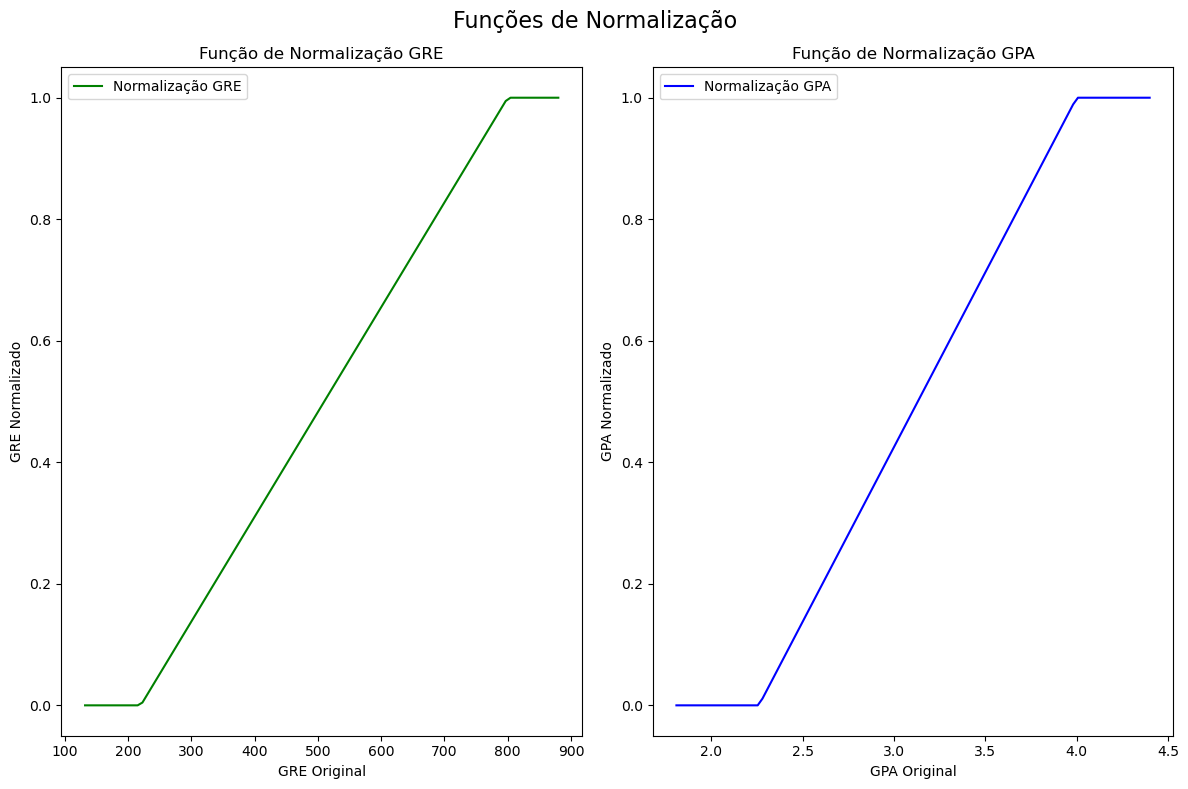

In [18]:
# Função de Normalização

# Determinando os valores máximos e mínimos das variáveis 'gre' e 'gpa' nos dados de treinamento
gre_max = max(X_train.gre)
gre_min = min(X_train.gre)

gpa_max = max(X_train.gpa)
gpa_min = min(X_train.gpa)

print(gre_max, gre_min, gpa_max, gpa_min)

# Realizando a normalização das variáveis 'gre' e 'gpa' nos dados de treinamento
X_train.gre = [(x - gre_min) / (gre_max - gre_min) for x in X_train.gre]
X_train.gpa = [(x - gpa_min) / (gpa_max - gpa_min) for x in X_train.gpa]

# Realizando a normalização das variáveis 'gre' e 'gpa' nos dados de teste
X_test.gre = [((x - gre_min) / (gre_max - gre_min)) 
              if ((x - gre_min) / (gre_max - gre_min) >= 0 and
                  (x - gre_min) / (gre_max - gre_min) <= 1)
              else 0
              if (x - gre_min) / (gre_max - gre_min) < 0 else 1 for x in X_test.gre]
X_test.gpa = [((x - gpa_min) / (gpa_max - gpa_min))
              if ((x - gpa_min) / (gpa_max - gpa_min) >= 0 and
                  (x - gpa_min) / (gpa_max - gpa_min) <= 1)
              else 0
              if (x - gpa_min) / (gpa_max - gpa_min) < 0 else 1 for x in X_test.gpa]

# Estatísticas Descritivas

# Exibindo as estatísticas descritivas dos dados de treinamento após a normalização
display(X_train.describe().T)

# Exibindo as estatísticas descritivas dos dados de teste após a normalização
display(X_test.describe().T)

# PLOT

# Criando uma série de valores para o eixo x que abrange um intervalo maior para a variável 'gre'
dd_gre = np.linspace(gre_min - gre_min * 0.4, gre_max * 1.1, 100)

# Criando uma série de valores para o eixo y que abrange um intervalo maior para a variável 'gpa'
dd_gpa = np.linspace(gpa_min - gpa_min * 0.2, gpa_max * 1.1, 100)

# Calculando a função de normalização para a variável 'gre'
im_gre = np.where(np.logical_and(
    (dd_gre - gre_min) / (gre_max - gre_min) >= 0,
    (dd_gre - gre_min) / (gre_max - gre_min) <= 1), 
    (dd_gre - gre_min) / (gre_max - gre_min), 
    np.where((dd_gre - gre_min) / (gre_max - gre_min) < 0, 0, 1))

# Calculando a função de normalização para a variável 'gpa'
im_gpa = np.where(np.logical_and(
    (dd_gpa - gpa_min) / (gpa_max - gpa_min) >= 0,
    (dd_gpa - gpa_min) / (gpa_max - gpa_min) <= 1), 
    (dd_gpa - gpa_min) / (gpa_max - gpa_min), 
    np.where((dd_gpa - gpa_min) / (gpa_max - gpa_min) < 0, 0, 1))

# Criando a figura e os subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
fig.suptitle('Funções de Normalização', fontsize=16)

# Plot da função de normalização para a variável GRE
ax1.plot(dd_gre, im_gre, 'g', label='Normalização GRE')
ax1.legend(loc='upper left')
ax1.set_xlabel('GRE Original')  # Adicionando rótulo ao eixo x
ax1.set_ylabel('GRE Normalizado')  # Adicionando rótulo ao eixo y
ax1.set_title('Função de Normalização GRE')  # Adicionando título ao subplot

# Plot da função de normalização para a variável GPA
ax2.plot(dd_gpa, im_gpa, 'b', label='Normalização GPA')
ax2.legend(loc='upper left')
ax2.set_xlabel('GPA Original')  # Adicionando rótulo ao eixo x
ax2.set_ylabel('GPA Normalizado')  # Adicionando rótulo ao eixo y
ax2.set_title('Função de Normalização GPA')  # Adicionando título ao subplot

plt.tight_layout()  # Melhorando o espaçamento entre os subplots
plt.show()

### 4.4) Verificação da Variável target

In [19]:
# Verificando o balanceamento da variável target
target_balance = m_data['admit'].value_counts(normalize=True) * 100

# Imprimindo os resultados
print("Balanceamento da variável target:")
print(target_balance)

# Observação sobre o balanceamento da variável target
if target_balance[0] < 30 or target_balance[1] < 30:
    print("O dataset está desbalanceado. Isso pode enviesar e/ou dificultar o modelo e seu treinamento.")
else:
    print("O dataset está levemente desbalanceado (entre 30% e 50%). Não vemos necessidade de utilizar técnicas de undersampling ou oversampling para este caso.")


Balanceamento da variável target:
0    68.25
1    31.75
Name: admit, dtype: float64
O dataset está levemente desbalanceado (entre 30% e 50%). Não vemos necessidade de utilizar técnicas de undersampling ou oversampling para este caso.


## 5) Criação do Modelo de Rede Neural

### 5.1) Criação do Modelo inicial

Para chegar nessa configuração, fizemos testes com diversas configurações a partir da documentação em https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [20]:
mlp = MLPClassifier(max_iter = 1000,
                    activation = 'identity',
                    hidden_layer_sizes = (6, 5, 4),
                    learning_rate = 'constant',
                    learning_rate_init = 0.1,
                    solver = 'adam',
                    alpha = 0.285,
                    random_state = RANDOMSTATE)
mlp

MLPClassifier(activation='identity', alpha=0.285, hidden_layer_sizes=(6, 5, 4),
              learning_rate_init=0.1, max_iter=1000, random_state=311)

### 5.2) Fit: Treinamento do Modelo Definido

In [21]:
mlp.fit(X_train, y_train)

MLPClassifier(activation='identity', alpha=0.285, hidden_layer_sizes=(6, 5, 4),
              learning_rate_init=0.1, max_iter=1000, random_state=311)

### 5.3) Predict do Modelo Definido a partir dos Dados de Teste

In [22]:
y_pred = mlp.predict(X_test)

### 5.4) Acurácia, Matriz de Confusão e Relatório de Métricas

In [23]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Accuracy: 0.84


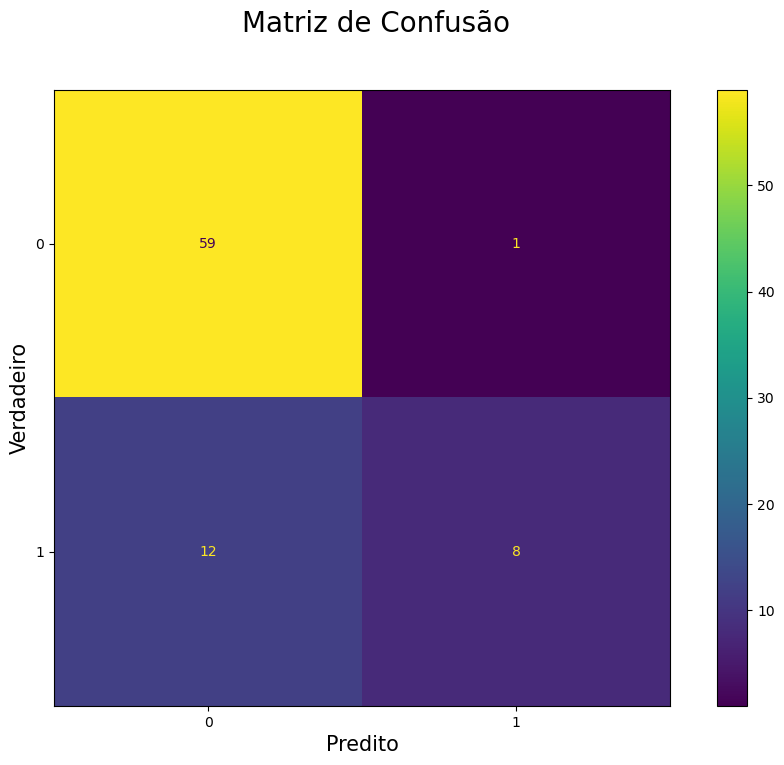

In [24]:
cmp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("Matriz de Confusão", fontsize = 20)
cmp.plot(ax=ax)
plt.xlabel('Predito', fontsize=15)
plt.ylabel('Verdadeiro', fontsize=15)
plt.show()

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90        60
           1       0.89      0.40      0.55        20

    accuracy                           0.84        80
   macro avg       0.86      0.69      0.73        80
weighted avg       0.85      0.84      0.81        80



### 5.5) Curva de Loss

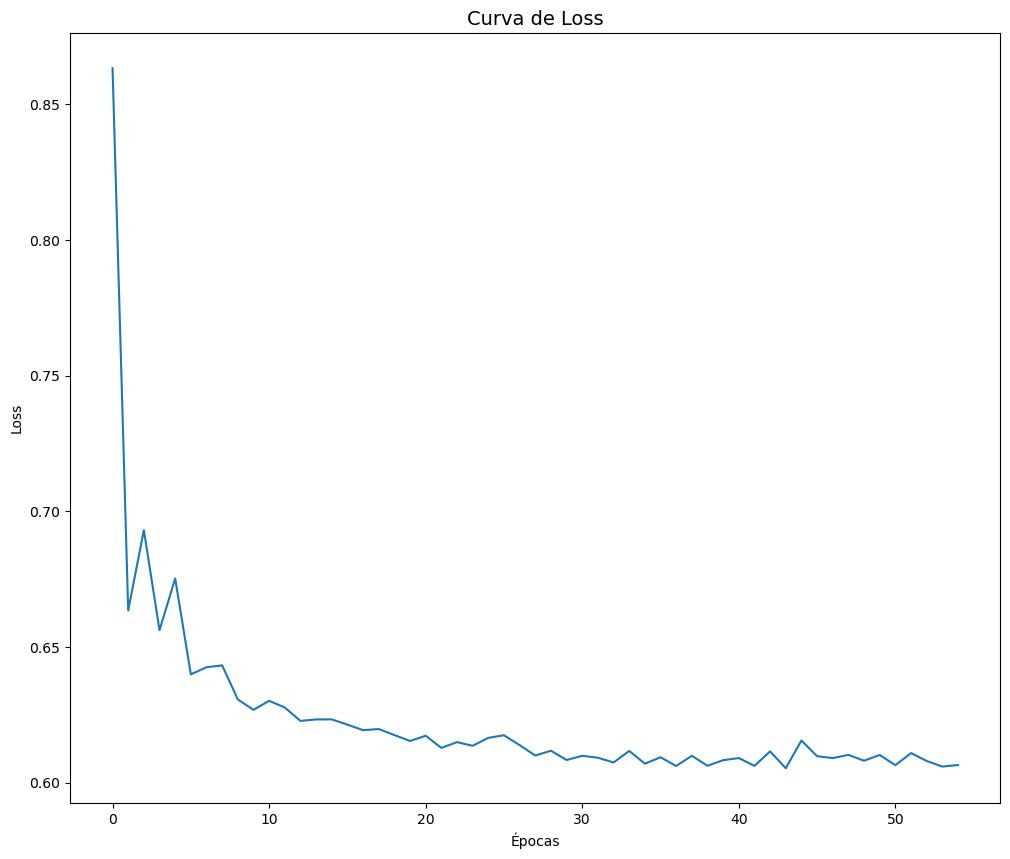

In [26]:
# Curva de Loss
fig, ax = plt.subplots(figsize=(12, 10))
plt.plot(mlp.loss_curve_)
plt.title("Curva de Loss", fontsize=14)
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.show()

## 6) Grid Search

Vamos executar o GridSearchCV para tentarmos encontrar hiperparâmetros melhores para o modelo.

### 6.1) Definição do grid de parâmetros à ser considerado

In [27]:
param_grid = [
    {
        'activation' : ['identity', 'relu', 'logistic'],
        'solver' : ['sgd', 'adam'],
        'hidden_layer_sizes': [
             (18, 15, 12, 9, 6, 3),
             (18, 9, 3),
             (9, 6, 3),
             (9, 3),
             (9,),
             (3,), 
         ],
        'learning_rate': ['constant', 'adaptive'], 
        'learning_rate_init': [0.01, 0.1, 1],
        'alpha': [0.001, 0.285, 0.570, 0.855],
        'max_iter': [100, 500, 1000],
        'batch_size': [32, 64, 128],
        'early_stopping': [True, False]
    }
]

### 6.2) Definição do GridSearch com os parâmetros definidos

Normalmente um valor de 5 ou 10 folds para validação cruzada é suficiente. Como temos um conjunto de dados relativamente pequeno e desejamos obter estimativas mais robustas, iremos utilizar 20 folds para a execução do `GridSearchCV`.

In [28]:
gs = GridSearchCV(MLPClassifier(verbose = 2,
                                random_state = RANDOMSTATE),
                                param_grid = param_grid,
                                n_jobs= -1,
                                cv = 20,
                                scoring = 'accuracy')

### 6.3) Fit: Execução do GridSearch

In [29]:
gs.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
7128 fits failed out of a total of 311040.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7128 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 747, in fit
    return self._fit(X, y, incremental=False)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 491, in _fit
    raise ValueEr

Iteration 1, loss = 1.30127672
Validation score: 0.625000
Iteration 2, loss = 1.10793248
Validation score: 0.656250
Iteration 3, loss = 1.00867994
Validation score: 0.656250
Iteration 4, loss = 0.95219223
Validation score: 0.656250
Iteration 5, loss = 0.90251929
Validation score: 0.656250
Iteration 6, loss = 0.86536110
Validation score: 0.687500
Iteration 7, loss = 0.83462460
Validation score: 0.687500
Iteration 8, loss = 0.81533130
Validation score: 0.687500
Iteration 9, loss = 0.78593514
Validation score: 0.718750
Iteration 10, loss = 0.76956618
Validation score: 0.656250
Iteration 11, loss = 0.76105894
Validation score: 0.718750
Iteration 12, loss = 0.76084784
Validation score: 0.656250
Iteration 13, loss = 0.73767555
Validation score: 0.687500
Iteration 14, loss = 0.72205836
Validation score: 0.687500
Iteration 15, loss = 0.72994412
Validation score: 0.656250
Iteration 16, loss = 0.72463210
Validation score: 0.687500
Iteration 17, loss = 0.70785313
Validation score: 0.656250
Iterat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.665625 0.678125 0.665625 ... 0.665625 0.665625 0.665625]
  warnings.warn(


GridSearchCV(cv=20, estimator=MLPClassifier(random_state=311, verbose=2),
             n_jobs=-1,
             param_grid=[{'activation': ['identity', 'relu', 'logistic'],
                          'alpha': [0.001, 0.285, 0.57, 0.855],
                          'batch_size': [32, 64, 128],
                          'early_stopping': [True, False],
                          'hidden_layer_sizes': [(18, 15, 12, 9, 6, 3),
                                                 (18, 9, 3), (9, 6, 3), (9, 3),
                                                 (9,), (3,)],
                          'learning_rate': ['constant', 'adaptive'],
                          'learning_rate_init': [0.01, 0.1, 1],
                          'max_iter': [100, 500, 1000],
                          'solver': ['sgd', 'adam']}],
             scoring='accuracy')

### 6.4) Melhores parâmetros encontrados

In [30]:
print(gs.best_params_)

{'activation': 'identity', 'alpha': 0.57, 'batch_size': 32, 'early_stopping': True, 'hidden_layer_sizes': (18, 15, 12, 9, 6, 3), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


### 6.5) Predict do Modelo Encontrado pelo Grid Search com os Dados de Teste


In [31]:
gs_pred = gs.predict(X_test)

### 6.6) Acurácia, Matriz de Confusão e Relatório de Métricas

In [32]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test.values.ravel(), gs_pred)))

Accuracy: 0.84


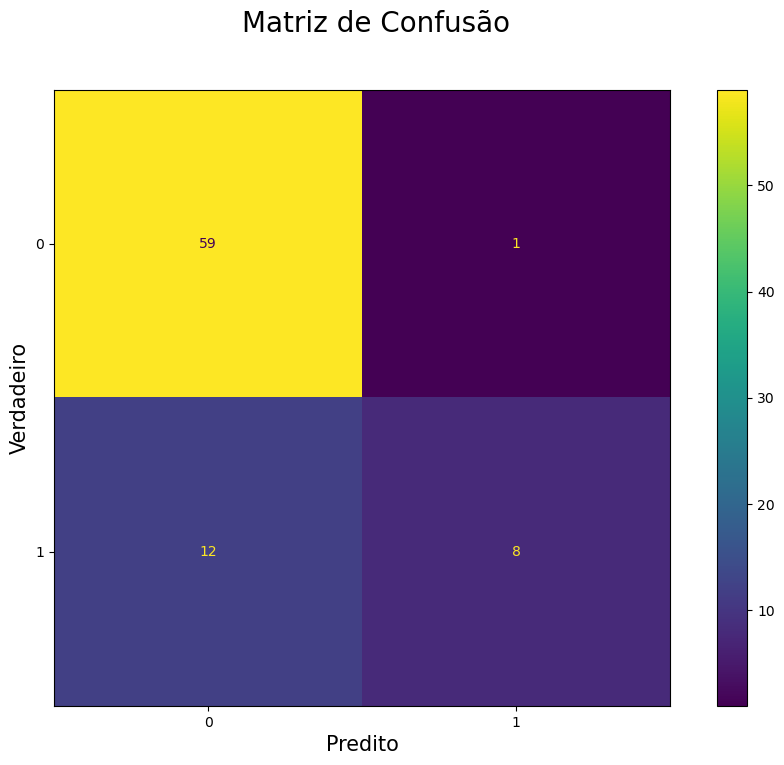

In [33]:
cmp = ConfusionMatrixDisplay(confusion_matrix(y_test, gs_pred))
fig, ax = plt.subplots(figsize = (12,8))
fig.suptitle("Matriz de Confusão", fontsize = 20)
cmp.plot(ax=ax)
plt.xlabel('Predito', fontsize = 15)
plt.ylabel('Verdadeiro', fontsize = 15)
plt.show()

In [34]:
print(classification_report(y_test, gs_pred))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90        60
           1       0.89      0.40      0.55        20

    accuracy                           0.84        80
   macro avg       0.86      0.69      0.73        80
weighted avg       0.85      0.84      0.81        80



## 7) Observações Finais

Comparando os dois modelos, podemos concluir que o modelo encontrado pelo GridSearchCV é mais complexo do que o modelo inicialmente estipulado. Isso pode ser observado em algumas diferenças-chave entre os modelos:

* Número de camadas e neurônios: O modelo inicial tinha três camadas ocultas com tamanhos de (6, 5, 4), enquanto o modelo encontrado pelo GridSearchCV possui seis camadas ocultas com tamanhos de (18, 15, 12, 9, 6, 3). Ter um maior número de camadas ocultas e mais neurônios em cada camada aumenta a complexidade do modelo.

* Parâmetros de otimização: Ambos os modelos utilizam o otimizador 'adam', mas a taxa de aprendizagem inicial é diferente entre eles. O modelo inicial tinha uma taxa de aprendizagem inicial de 0.1, enquanto o modelo encontrado pelo GridSearchCV tinha uma taxa de aprendizagem inicial de 0.01. Uma taxa de aprendizagem menor geralmente resulta em um ajuste mais lento dos pesos do modelo.

* Parâmetros adicionais: O modelo encontrado pelo GridSearchCV inclui parâmetros extras, como 'batch_size' (tamanho do lote durante o treinamento), 'early_stopping' (parada antecipada do treinamento com base na melhoria) e 'max_iter' (número máximo de iterações). Colocamos esses e outros parâmetros para o GridSearchCV, pois no estudo feito durante o trabalho não conseguimos um modelo usando estes parâmetros com bom resultado. Apesar disso, o GridSearchCV foi capaz de encontrar uma combinação com bom resultado, porém temos em mente que, mesmo esses parâmetros adicionais fornecendo mais controle e flexibilidade durante o treinamento, eles também aumentam a complexidade do modelo.

Podemos concluir que o modelo encontrado pelo GridSearchCV é mais complexo em comparação com o modelo inicialmente estipulado.  É importante levar em consideração a complexidade do modelo ao avaliar sua interpretabilidade, tempo de treinamento e capacidade de generalização para dados futuros.

<hr style="height:2px; color:#21618C; background-color:#000; border:none;">